#### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.inspection import permutation_importance

#### Load the antibody and metadata

In [2]:
antibody_data =pd.read_csv("plasma_ab_titer_batchCorrected_data.tsv", sep='\t')
antibody_data.head()

,1,19,27,37,45,55,70,77,2,20,...,1014,1417,1206,1074,962,977,1276,1107,1392,1339
IgG_PT,2.979295,0.840128,1.609969,3.028724,0.124780,0.355498,0.130842,-0.024371,1.779168,0.529309,...,2.834546,2.228887,1.526832,1.844145,1.603756,1.488369,21.402168,1.440292,3.485581,1.844145
IgG_PRN,2.006372,5.248238,3.975809,3.717675,0.393764,0.852770,0.435633,0.378719,1.215558,3.732547,...,-1.211079,4.013768,0.161565,0.467727,9.703308,1.442700,-1.718901,2.064514,3.109803,0.902228
IgG_FHA,26.636688,1.732962,1.696552,0.968178,1.190998,1.324519,1.188472,0.983486,4.258893,1.471498,...,0.199095,-2.397737,-0.848591,1.983019,1.440536,1.161187,3.365389,-1.237607,22.740466,1.814005
IgG1_PT,10.098853,-2.168427,2.946572,10.351228,-4.949479,-4.654924,-5.114467,-5.114467,12.070053,-1.310069,...,3.205278,3.609428,3.722697,3.574863,4.240116,3.353112,68.363113,4.757535,5.485538,2.687859
IgG1_PRN,2.044475,3.008599,2.451276,2.616303,-0.055424,0.867244,-0.027700,-0.048400,2.120394,3.094482,...,0.338634,1.873826,0.687858,0.779421,3.311236,1.255116,1.778375,1.394394,2.008831,0.729597


In [3]:
metadata =pd.read_csv("subject_specimen.tsv", sep='\t')
metadata


,specimen_id,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost
0,1,1,2020_dataset,0,wP,Female,2016-09-12
1,2,1,2020_dataset,1,wP,Female,2016-09-12
2,3,1,2020_dataset,3,wP,Female,2016-09-12
3,4,1,2020_dataset,7,wP,Female,2016-09-12
4,5,1,2020_dataset,14,wP,Female,2016-09-12
...,...,...,...,...,...,...,...
891,1486,169,2023_dataset,-14,aP,Male,2023-09-05
892,1487,169,2023_dataset,0,aP,Male,2023-09-05
893,1494,171,2023_dataset,-30,wP,Female,2023-11-13
894,1496,171,2023_dataset,-14,wP,Female,2023-11-13


## 1. Descriptive Statistics

#### (i) Antibody Data

In [4]:
antibody_data = antibody_data.T
antibody_data.reset_index(inplace=True)
antibody_data.rename(columns={"index": "specimen_id"}, inplace=True)
antibody_data.info()
antibody_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   specimen_id  867 non-null    object 
 1   IgG_PT       867 non-null    float64
 2   IgG_PRN      867 non-null    float64
 3   IgG_FHA      867 non-null    float64
 4   IgG1_PT      867 non-null    float64
 5   IgG1_PRN     867 non-null    float64
 6   IgG1_FHA     867 non-null    float64
 7   IgG1_FIM2/3  867 non-null    float64
 8   IgG1_TT      867 non-null    float64
 9   IgG1_DT      867 non-null    float64
 10  IgG1_OVA     867 non-null    float64
 11  IgG2_PT      867 non-null    float64
 12  IgG2_PRN     867 non-null    float64
 13  IgG2_FHA     867 non-null    float64
 14  IgG2_FIM2/3  867 non-null    float64
 15  IgG2_TT      867 non-null    float64
 16  IgG2_DT      867 non-null    float64
 17  IgG2_OVA     867 non-null    float64
 18  IgG3_PT      867 non-null    float64
 19  IgG3_PRN

,IgG_PT,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2/3,IgG1_TT,IgG1_DT,IgG1_OVA,...,IgG3_TT,IgG3_DT,IgG3_OVA,IgG4_PT,IgG4_PRN,IgG4_FHA,IgG4_FIM2/3,IgG4_TT,IgG4_DT,IgG4_OVA
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,...,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,2.992093,2.232264,4.116975,7.619227,1.596268,2.000590,4.892378,1.293253,1.612136,3.956049,...,5.594563,4.175403,3.055292,37.874338,17.203594,6.089924,21.202790,6.311572,2.382220,1.481309
std,3.373499,3.650792,8.616865,13.137822,1.005188,2.051332,5.497166,0.793983,1.323110,7.272540,...,14.404081,8.758549,6.552822,99.044161,36.960998,10.409450,64.069405,11.813025,3.117253,1.577649
min,-3.284043,-4.062694,-5.474723,-5.114467,-0.379954,-1.742370,-1.958820,-1.110244,-0.977179,-1.551499,...,-2.671436,-3.902546,-1.957055,-12.393755,-4.236029,-2.581847,-9.338632,-0.929298,-0.240594,-0.085238
25%,0.693087,0.479498,0.954403,-0.907498,0.772004,0.744549,0.742529,0.712489,0.513678,0.271674,...,0.117487,-0.186280,-0.456639,-3.732561,0.111912,0.041880,0.644320,0.189807,0.489195,0.268029
50%,1.921069,1.143478,2.302218,4.055323,1.711787,1.530104,3.803407,1.389511,1.576552,0.995146,...,1.257341,0.893202,0.232142,14.640182,1.615749,1.333968,5.608794,1.512404,1.367948,1.013318
75%,4.429809,4.400705,4.687214,9.964299,2.470448,3.111154,8.178330,1.907611,2.560986,4.186516,...,4.170348,4.520578,3.596762,33.513747,18.051756,8.302269,13.042149,6.805248,3.059109,2.121910
max,23.519058,33.997417,122.278364,88.283744,4.312651,12.949467,35.875396,5.014429,6.971486,46.063229,...,171.741434,59.234337,39.612816,1033.317787,241.198019,83.631069,886.871866,80.197015,23.322799,8.115342


- Columns - specimen_id (866)
- Rows - Antibody (31)

##### Metadata has 896 specimen_id while antibody_data has 867 specimen_id. Therefore, checking which specimen ids from metadata matches to columns of antibody_data

In [5]:
metadata['specimen_id'] = metadata['specimen_id'].astype(str)
antibody_data['specimen_id'] = antibody_data['specimen_id'].astype(str)

metadata_ids = set(metadata['specimen_id'])
antibody_data_ids = set(antibody_data['specimen_id'])

matching_ids = metadata_ids.intersection(antibody_data_ids)

 #### (ii) Merging metadata and antibody data (specimen_id)

In [6]:
data = pd.merge(metadata, antibody_data, on='specimen_id', how='inner')
data

,specimen_id,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost,IgG_PT,IgG_PRN,IgG_FHA,...,IgG3_TT,IgG3_DT,IgG3_OVA,IgG4_PT,IgG4_PRN,IgG4_FHA,IgG4_FIM2/3,IgG4_TT,IgG4_DT,IgG4_OVA
0,1,1,2020_dataset,0,wP,Female,2016-09-12,2.979295,2.006372,26.636688,...,1.257341,2.712350,2.258461,-3.679833,9.723329,0.701456,0.644320,2.818807,1.092586,2.833653
1,2,1,2020_dataset,1,wP,Female,2016-09-12,1.779168,1.215558,4.258893,...,1.257341,2.438411,3.194867,-3.732561,7.094228,0.549357,0.644320,2.244171,1.010626,2.006183
2,3,1,2020_dataset,3,wP,Female,2016-09-12,2.585083,1.770652,8.716468,...,1.257341,2.581606,3.194867,-3.377425,5.824065,0.488220,0.657847,2.117521,0.809889,3.406585
3,4,1,2020_dataset,7,wP,Female,2016-09-12,8.761066,5.252938,0.968178,...,4.525442,2.992516,4.599476,-2.288755,16.395098,1.253187,39.833287,2.855441,2.305151,2.612061
4,5,1,2020_dataset,14,wP,Female,2016-09-12,10.089424,5.565815,0.968178,...,3.731061,2.108438,5.067678,-2.772608,19.987064,1.281519,42.834840,2.782172,2.450570,2.278020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,1486,169,2023_dataset,-14,aP,Male,2023-09-05,1.707240,-0.073958,-2.432732,...,24.784548,11.122293,6.058944,28.936183,-0.462121,0.633684,5.608794,0.147821,2.231081,1.520146
863,1487,169,2023_dataset,0,aP,Male,2023-09-05,1.256727,-0.089344,-2.432732,...,20.304730,8.654271,5.056944,31.224965,-0.474093,0.764264,5.608794,0.147821,2.143760,1.451198
864,1494,171,2023_dataset,-30,wP,Female,2023-11-13,1.355524,-0.961054,9.529786,...,3.199969,1.050097,-1.706555,40.295322,4.673972,4.289924,137.235245,6.883103,8.150467,0.653370
865,1496,171,2023_dataset,-14,wP,Female,2023-11-13,1.466176,-0.361886,11.192057,...,0.756432,1.050097,-1.706555,40.295322,4.673972,4.289924,126.011284,6.883103,4.175426,0.673069


## 2. Timepoint Analysis

#### (i) Antibody level over time in each patient

/var/folders/6f/wh6m6kqx1sn0fxgvj7fww4wm0000gn/T/ipykernel_66228/1755481346.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


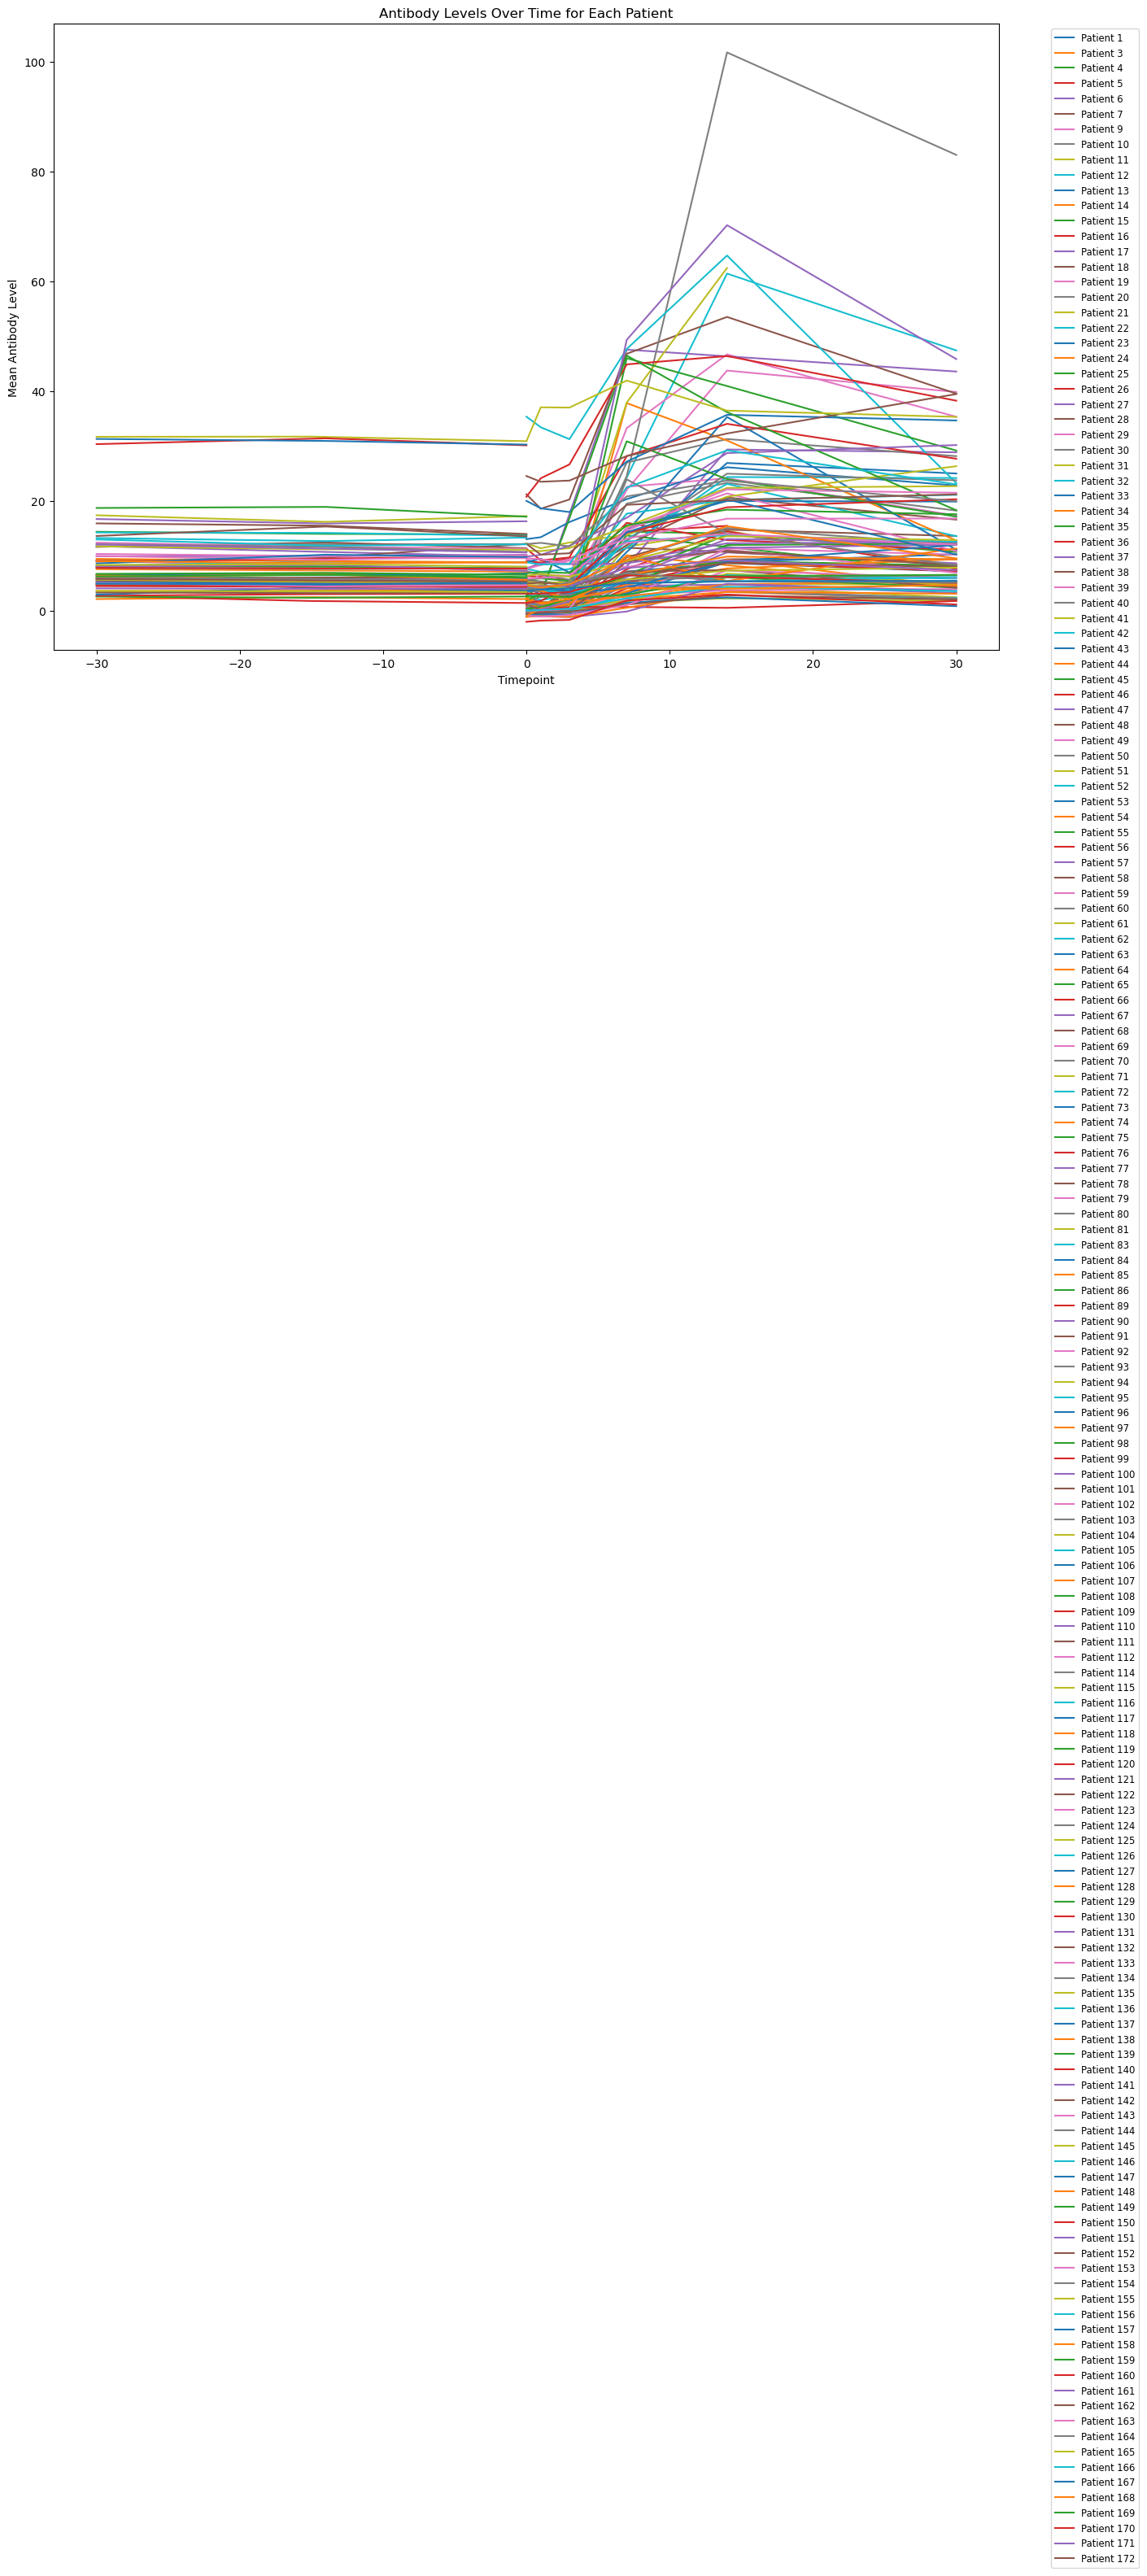

In [7]:
data.columns = data.columns.map(str)

antibody_columns = [col for col in data.columns if col.startswith("IgG")]
data[antibody_columns] = data[antibody_columns].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(15, 10))  
for patient_id, group in data.groupby('subject_id'):
    group = group.sort_values('timepoint')
    
    # X-axis: timepoints, Y-axis: mean antibody levels
    x = group['timepoint']
    y = group[antibody_columns].mean(axis=1) 

    plt.plot(x, y, label=f'Patient {patient_id}')

plt.xlabel('Timepoint')
plt.ylabel('Mean Antibody Level')
plt.title('Antibody Levels Over Time for Each Patient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xticks()  
plt.tight_layout()

plt.show()

#### (ii) Antibody level over time in patient_id = 1

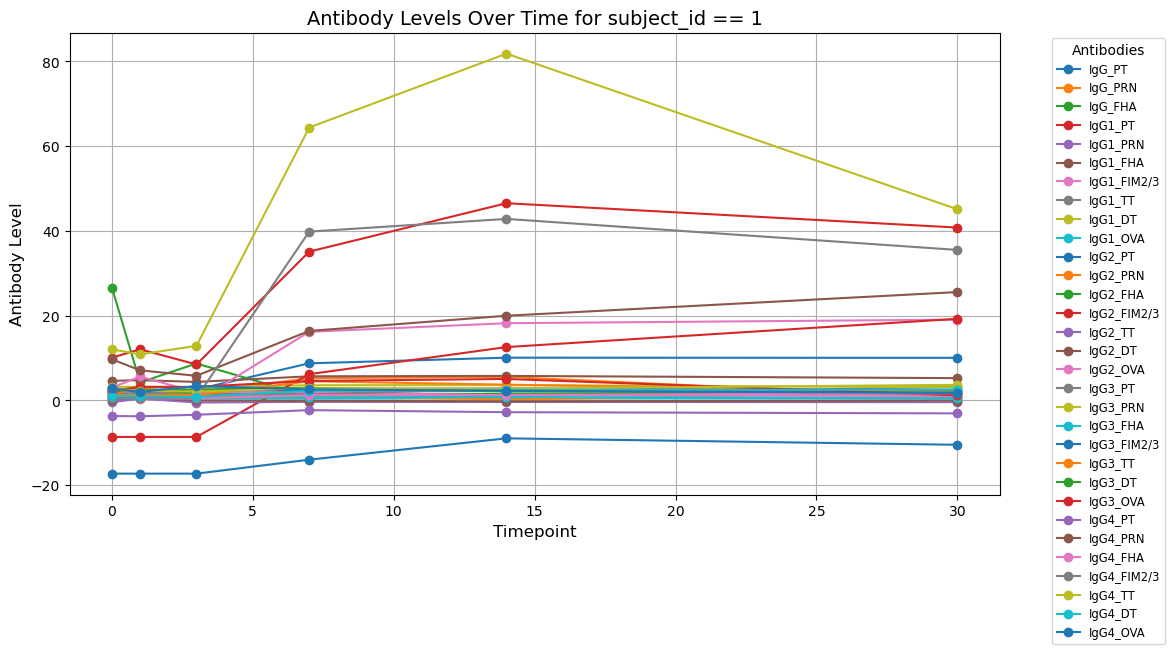

In [8]:
data.columns = data.columns.map(str)

antibody_columns = [col for col in data.columns if col.startswith("IgG")]

data[antibody_columns] = data[antibody_columns].apply(pd.to_numeric, errors='coerce')

subject_data = data[data['subject_id'] == 1]
subject_data = subject_data.sort_values(by='timepoint')

plt.figure(figsize=(12, 6))

for antibody in antibody_columns:
    plt.plot(
        subject_data['timepoint'], 
        subject_data[antibody], 
        marker='o',
        label=antibody
    )

plt.title("Antibody Levels Over Time for subject_id == 1", fontsize=14)
plt.xlabel("Timepoint", fontsize=12)
plt.ylabel("Antibody Level", fontsize=12)
plt.legend(title="Antibodies", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

#### (iii) Performing one-way ANOVA

In [9]:
# Filter data for the antibody of interest
antibody_column = 'IgG_PT'
data_filtered = data[['timepoint', antibody_column]]

# Group data by timepoint
groups = [group[antibody_column].dropna() for _, group in data_filtered.groupby('timepoint')]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA Results for {antibody_column}:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Significant differences exist between timepoints.")
else:
    print("No significant differences found between timepoints.")

ANOVA Results for IgG_PT:
F-statistic: 24.4426
P-value: 4.9321e-34
Significant differences exist between timepoints.


In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data for Tukey's HSD (pairwise comparisons between all timepoints)
tukey_results = pairwise_tukeyhsd(endog=data_filtered[antibody_column], 
                                  groups=data_filtered['timepoint'], 
                                  alpha=0.05)

print(tukey_results.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   -30    -15  -0.7865 0.9819 -3.1381 1.5652  False
   -30    -14    0.114    1.0 -1.5883 1.8162  False
   -30      0   -0.793 0.6451 -2.1225 0.5364  False
   -30      1  -1.2617 0.1311 -2.6865 0.1632  False
   -30      3  -1.3596 0.0761  -2.787 0.0678  False
   -30      7   1.2562 0.1383 -0.1738 2.6862  False
   -30     14   2.8127    0.0  1.3853 4.2401   True
   -30     30   1.7307 0.0059  0.2954  3.166   True
   -15    -14   0.9004 0.9671 -1.5456 3.3464  False
   -15      0  -0.0066    1.0 -2.2094 2.1963  False
   -15      1  -0.4752 0.9993 -2.7369 1.7865  False
   -15      3  -0.5732 0.9972 -2.8365 1.6902  False
   -15      7   2.0427 0.1155 -0.2223 4.3076  False
   -15     14   3.5992    0.0  1.3358 5.8625   True
   -15     30   2.5171  0.017  0.2488 4.7855   True
   -14      0   -0.907 0.6189  -2.397  0.583  False
   -14      

## 3. Comparative Analysis

#### (i) Effect of vaccination type on Antibody Titer

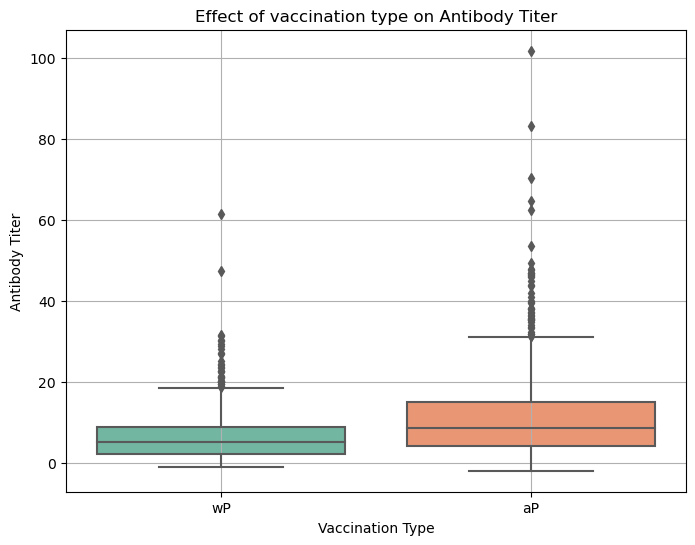

In [11]:
data['Antibody Titer'] = data.loc[:, data.columns.str.startswith('IgG')].mean(axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(x='infancy_vac', y='Antibody Titer', data=data, palette='Set2')
plt.title('Effect of vaccination type on Antibody Titer')
plt.xlabel('Vaccination Type')
plt.ylabel('Antibody Titer')
plt.grid(True)
plt.show()

#### (ii) Effect of gender on Antibody Titer

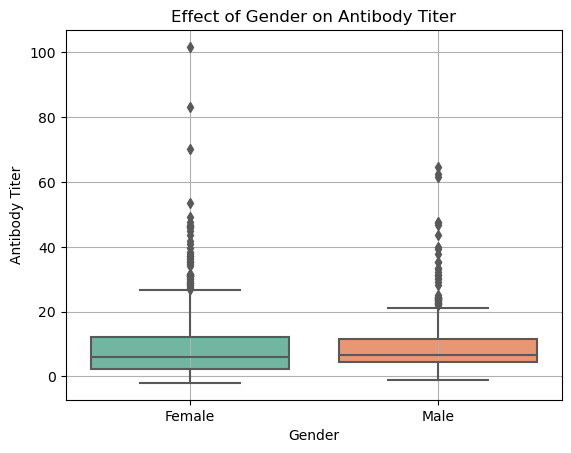

In [12]:
sns.boxplot(x='biological_sex', y='Antibody Titer', data=data, palette='Set2')
plt.title('Effect of Gender on Antibody Titer')
plt.xlabel('Gender')
plt.ylabel('Antibody Titer')
plt.grid(True)
plt.show()

## 4. Correlation

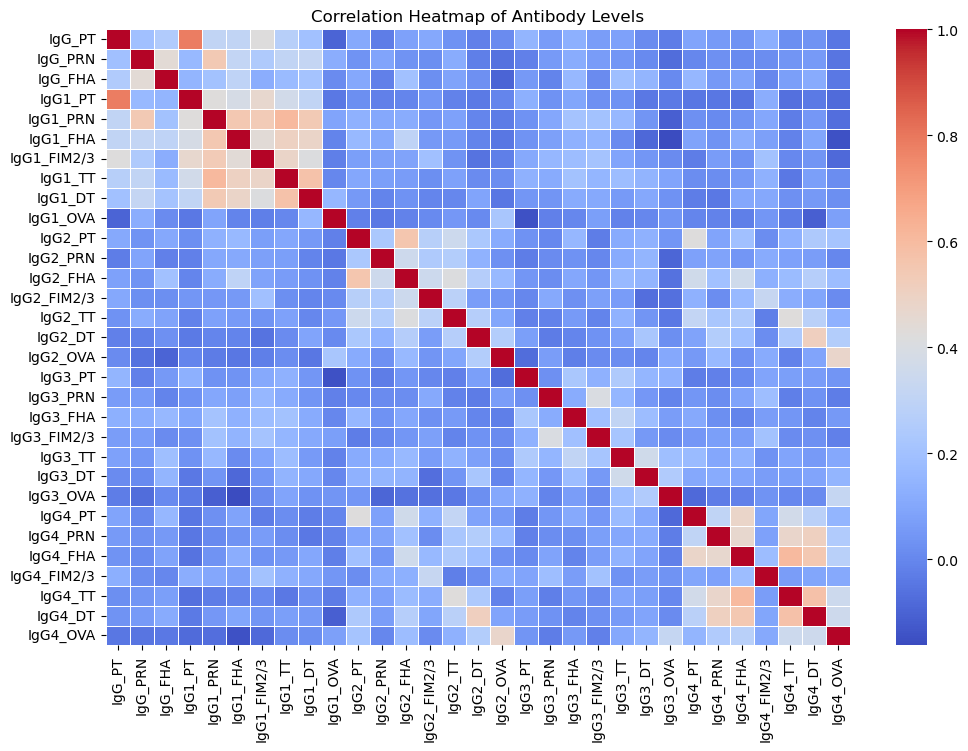

In [13]:
data_subset = data[antibody_columns]

# Calculate the correlation matrix
correlation_matrix = data_subset.corr()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Antibody Levels')
plt.show()

###### Interpretation:
Some IgG subtypes like IgG1_PT, IgG2_PT, IgG3_PT, and IgG4_PT show strong correlations with similar subtypes across different conditions (e.g., IgG1_PT with IgG1_FHA or IgG1_PRN). This suggests that antibody levels for these subtypes are likely influenced in parallel under certain conditions.


## 5. Dimensionality Reduction

#### (i) PCA

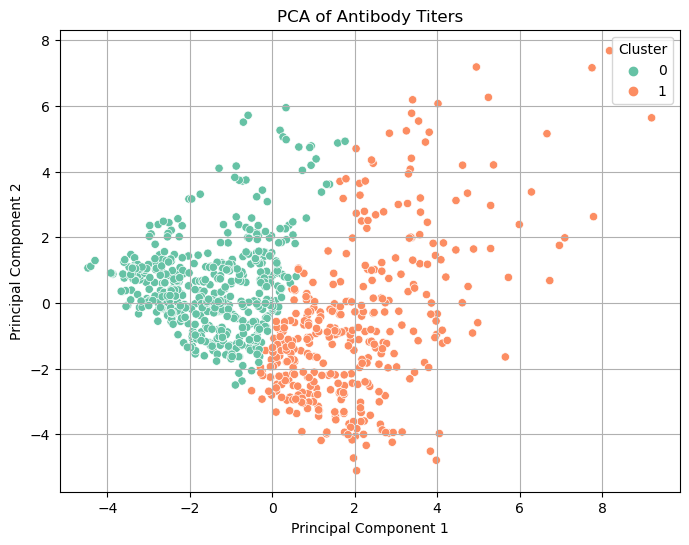

In [14]:
antibody_columns = [col for col in data.columns if col.startswith('IgG')]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[antibody_columns]) 

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Add the PCA results to the data
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=data)
plt.title('PCA of Antibody Titers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

#### (ii) UMAP

/Users/vaishnaveethote/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


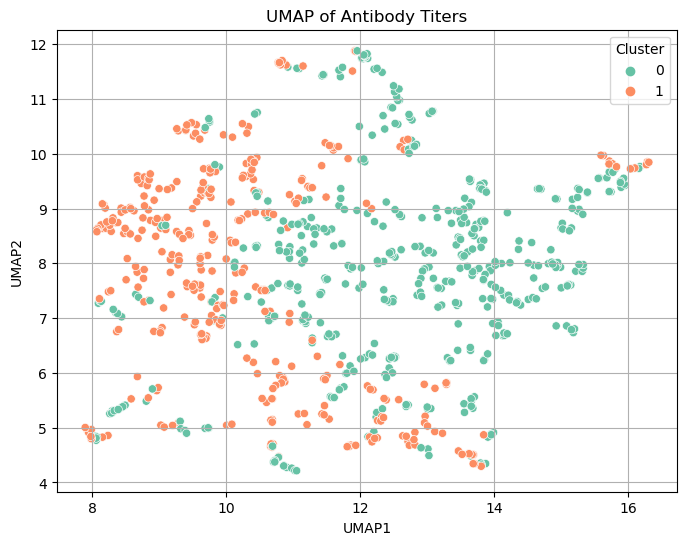

In [15]:
# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(data_scaled)

# Add the UMAP results to the data
data['UMAP1'] = umap_result[:, 0]
data['UMAP2'] = umap_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='Set2', data=data)
plt.title('UMAP of Antibody Titers')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)
plt.show()

## 6. Clustering

#### (i) k-means clustering

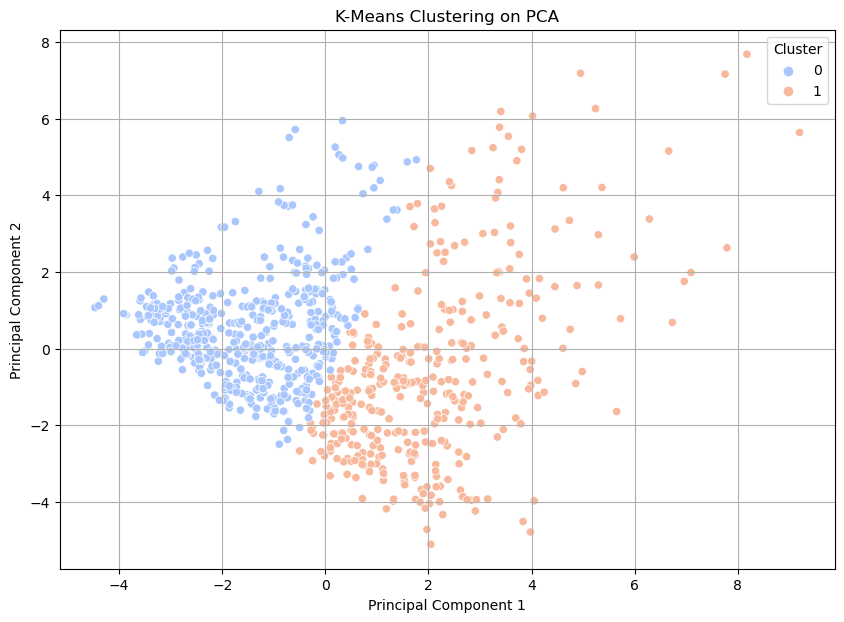

In [16]:
# Apply KMeans clustering on the PCA results
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result)

# Add the KMeans cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans_pca_labels

# Visualize the clusters in PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='coolwarm')
plt.title('K-Means Clustering on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


#### (ii) Hierarchial Clustering

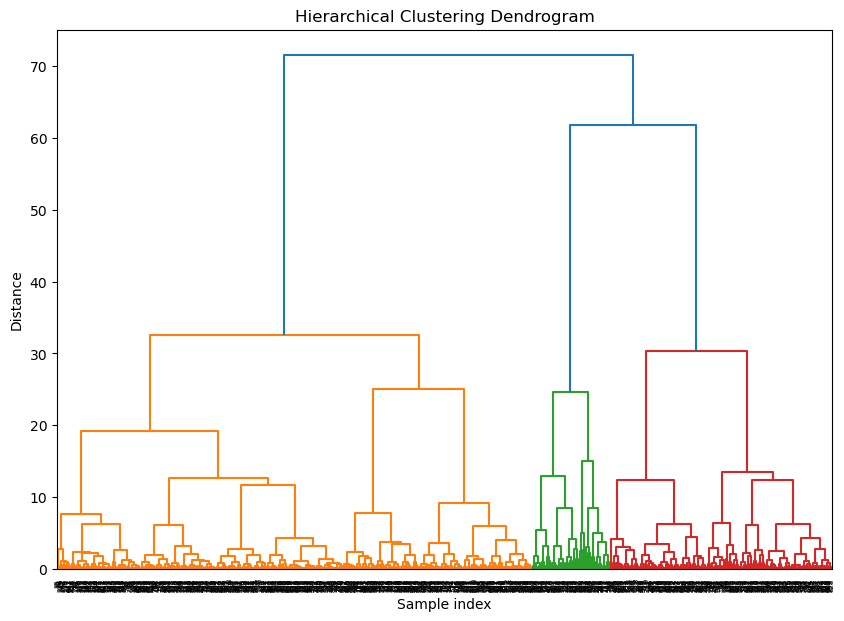

In [17]:
# Compute the linkage matrix
Z = sch.linkage(pca_result, method='ward')

# Create a dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

## 7. Logistic Regression

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Accuracy: 0.7417
Accuracy: 0.7529
F1 Score: 0.7034
AUC-ROC Score: 0.8359
Classification Report:
               precision    recall  f1-score   support

          aP       0.78      0.64      0.70        80
          wP       0.73      0.85      0.79        94

    accuracy                           0.75       174
   macro avg       0.76      0.74      0.75       174
weighted avg       0.76      0.75      0.75       174



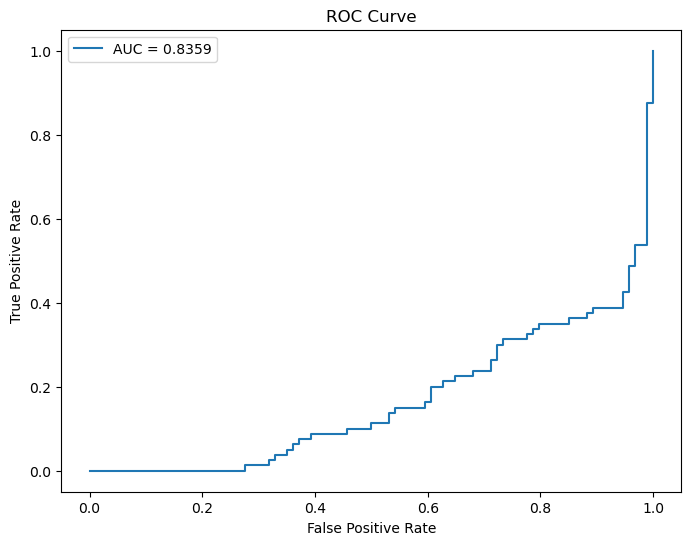

In [20]:
# Split data
X = data[antibody_columns]  # Antibody levels (features)
y = data['infancy_vac']     # Vaccination type (target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Define the refined parameter grid for GridSearchCV
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1], 'solver': ['lbfgs', 'liblinear']},
]

# Initialize GridSearchCV
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search_log_reg.fit(X_train_scaled, y_train)

# Get the best model
best_log_reg = grid_search_log_reg.best_estimator_

# Predict on the test set
y_pred_log_reg = best_log_reg.predict(X_test_scaled)
y_probs_log_reg = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label='aP')  # Adjust pos_label if needed
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# Print results
print("Best parameters: ", grid_search_log_reg.best_params_)
print("Best Logistic Regression Accuracy: {:.4f}".format(grid_search_log_reg.best_score_))
print("Accuracy: {:.4f}".format(accuracy_log_reg))
print("F1 Score: {:.4f}".format(f1_log_reg))
print("AUC-ROC Score: {:.4f}".format(roc_auc_log_reg))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_log_reg:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 8. Support Vector Machine

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVM Accuracy: 0.9192263580439995
Accuracy: 0.8851
F1 Score: 0.8780
AUC-ROC Score: 0.9448
Classification Report:
               precision    recall  f1-score   support

          aP       0.86      0.90      0.88        80
          wP       0.91      0.87      0.89        94

    accuracy                           0.89       174
   macro avg       0.88      0.89      0.88       174
weighted avg       0.89      0.89      0.89       174



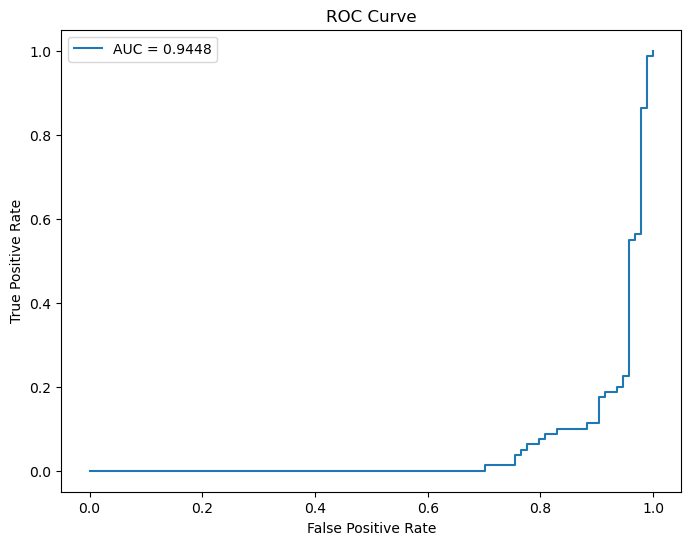

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................

In [21]:
# SVM hyperparameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'linear']
}

# GridSearchCV for SVM
svm_grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)
svm_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_svm = svm_grid_search.best_estimator_

# Predict on the test set
y_pred_svm = best_svm.predict(X_test_scaled)
y_probs_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, pos_label='aP')  # Adjust pos_label if needed
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Best parameters and accuracy
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_svm))
print("F1 Score: {:.4f}".format(f1_svm))
print("AUC-ROC Score: {:.4f}".format(roc_auc_svm))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_svm, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_svm:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 9. Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Accuracy: 0.9408090918569492
Accuracy: 0.9195
F1 Score: 0.9091
AUC-ROC Score: 0.9814
Classification Report:
               precision    recall  f1-score   support

          aP       0.95      0.88      0.91        80
          wP       0.90      0.96      0.93        94

    accuracy                           0.92       174
   macro avg       0.92      0.92      0.92       174
weighted avg       0.92      0.92      0.92       174



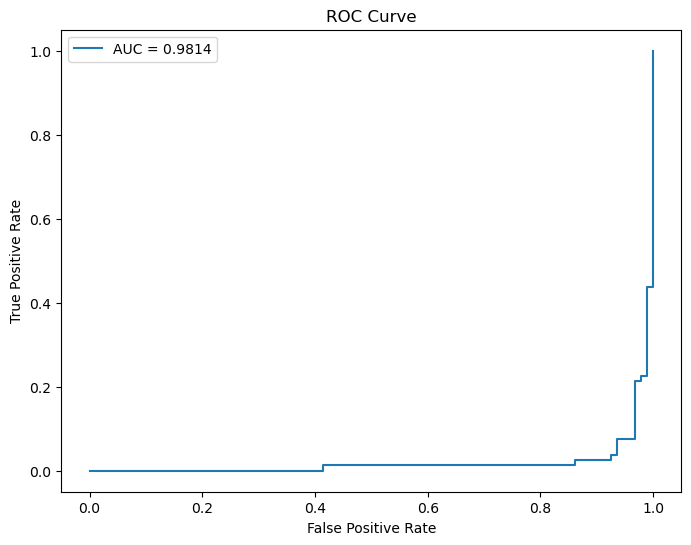

In [30]:
# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)
rf_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_rf = rf_grid_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_probs_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, pos_label='aP')  
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# Best parameters and accuracy
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_rf))
print("F1 Score: {:.4f}".format(f1_rf))
print("AUC-ROC Score: {:.4f}".format(roc_auc_rf))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ROC Curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_probs_rf, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_rf:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## 10. XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Accuracy: 0.9595766864769054
Accuracy: 0.9368
F1 Score: 0.9317
AUC-ROC Score: 0.9807
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93        80
           1       0.95      0.94      0.94        94

    accuracy                           0.94       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.94      0.94      0.94       174



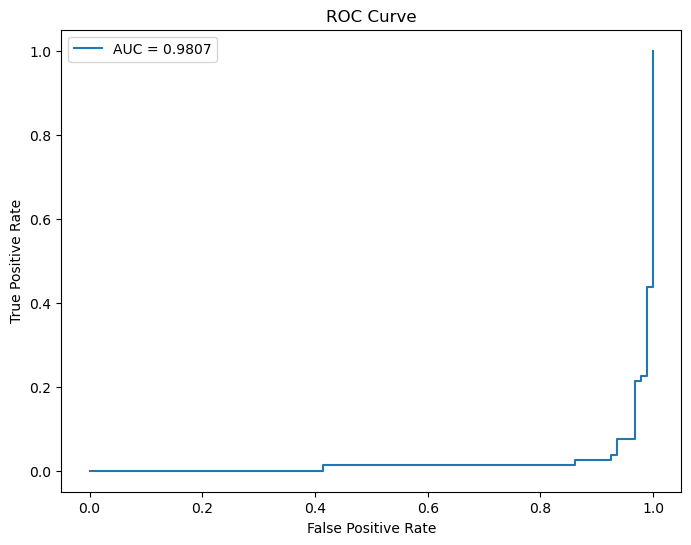

In [23]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Apply encoding on y_train
y_test_encoded = label_encoder.transform(y_test)        # Apply encoding on y_test

# Define the XGBoost model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",  
    verbosity=0            
)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],   
    "max_depth": [3, 5, 7],             
    "learning_rate": [0.01, 0.05, 0.1, 0.2],   
    "subsample": [0.6, 0.8, 1.0],              
    "colsample_bytree": [0.6]        
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train_encoded)

# Get the best model
best_xgb = grid_search.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_probs_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, pos_label=label_encoder.transform(['aP'])[0])  # Adjust 'aP' if needed
roc_auc_xgb = roc_auc_score(y_test_encoded, y_probs_xgb)

# Best parameters and accuracy
print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy:", grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_xgb))
print("F1 Score: {:.4f}".format(f1_xgb))
print("AUC-ROC Score: {:.4f}".format(roc_auc_xgb))

# Print classification report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_xgb))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_xgb:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [28]:
# Encode the target variable
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # 'aP' -> 1, 'wP' -> 0


In [31]:
# Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm, pos_label='aP')
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf, pos_label='aP')
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# XGBoost
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb, pos_label='aP')
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)

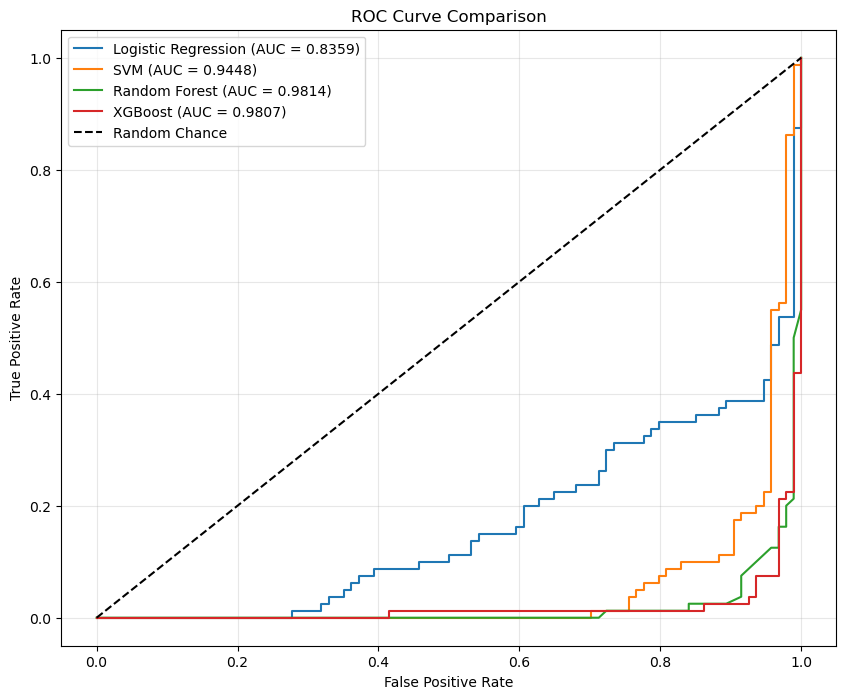

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_e

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_esti

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_e

In [32]:
import matplotlib.pyplot as plt

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {roc_auc_log_reg:.4f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Add plot details
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

## 11. Feature Importance

feature importance will provide insights into which antibodies are most predictive of the target variable.

### Random Forest

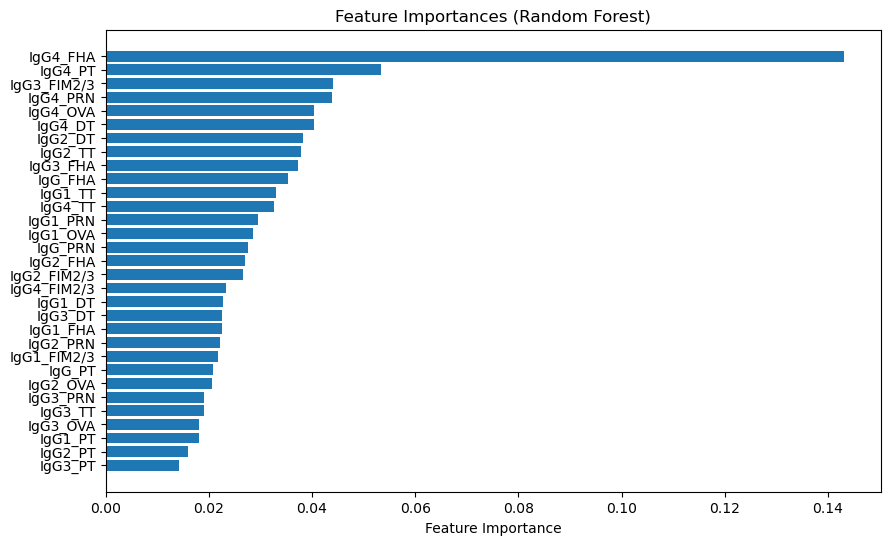

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_est

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_e

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_es

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_

In [24]:
# Get the best Random Forest model
best_rf = rf_grid_search.best_estimator_

# Get feature importances
importances_rf = best_rf.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
sorted_idx_rf = importances_rf.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx_rf], 
    importances_rf[sorted_idx_rf], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

### XGBoost

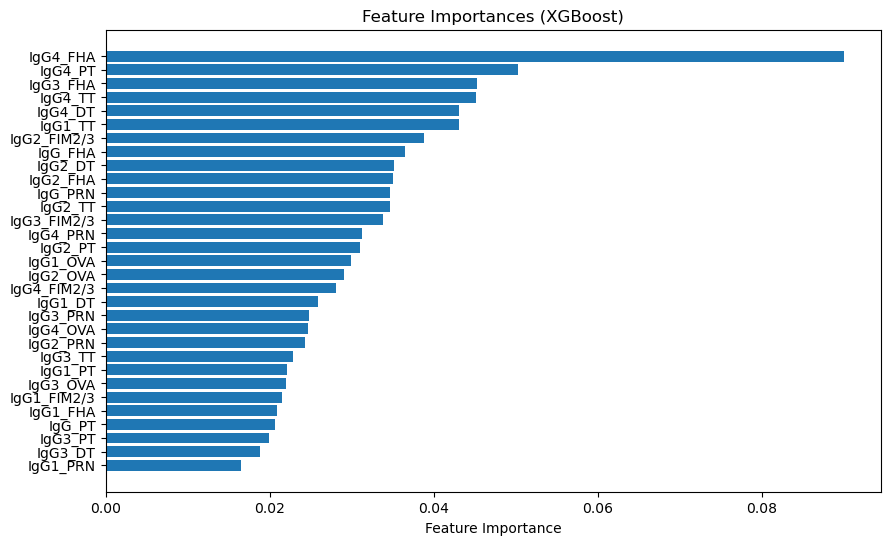

In [25]:
# Get the best XGBoost model
best_gb = grid_search.best_estimator_

# Get feature importances
importances_gb = best_gb.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
sorted_idx_gb = importances_gb.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx_gb], 
    importances_gb[sorted_idx_gb], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

### Support Vector Machine

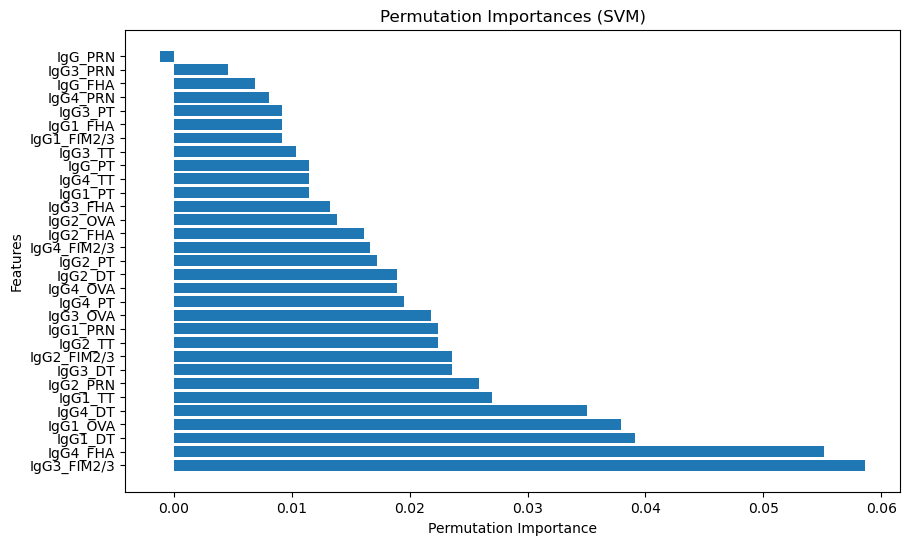

In [26]:
# Get the best model from GridSearchCV
best_svm = svm_grid_search.best_estimator_

# Compute permutation importances
result = permutation_importance(best_svm, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances = result.importances_mean

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importances (SVM)')
plt.show()

### Logistic Regression

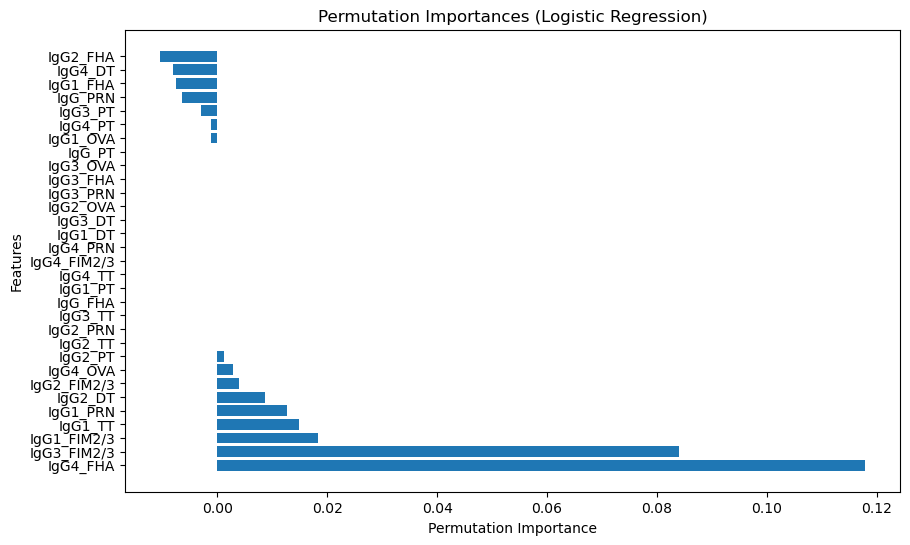

In [27]:
# Get the best model from GridSearchCV
best_log_reg = grid_search_log_reg.best_estimator_

# Compute permutation importances
result_log_reg = permutation_importance(best_log_reg, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances_log_reg = result_log_reg.importances_mean

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx_log_reg = np.argsort(importances_log_reg)[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx_log_reg], importances_log_reg[sorted_idx_log_reg], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importances (Logistic Regression)')
plt.show()

## 12. Comparing Results

In [27]:
data = [
    ["Logistic Regression", f"{accuracy_log_reg:.4f}", f"{roc_auc_log_reg:.4f}"],
    ["SVM", f"{accuracy_svm:.4f}", f"{roc_auc_svm:.4f}"],
    ["Random Forest", f"{accuracy_rf:.4f}", f"{roc_auc_rf:.4f}"],
    ["XGBoost", f"{accuracy_xgb:.4f}", f"{roc_auc_xgb:.4f}"]
]

# Define headers for the table
headers = ["Model", "Accuracy", "AUROC"]

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=headers)


print(df.to_string(index=False))

              Model Accuracy  AUROC
Logistic Regression   0.7529 0.8359
                SVM   0.8851 0.9448
      Random Forest   0.9195 0.9814
            XGBoost   0.9368 0.9807
